In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import statsmodels.nonparametric.api as smnp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import norm
Z = norm.ppf

In [193]:
rencode=pd.read_csv('data/rencode_cxtlocBEHAVEeeg.csv', header=0, usecols=['sub', 'cond', 'cxtcond', 'old/new', 'recog_answer', 'refresh_medsplit',
       'recog confidence', 'refresh dist', 'loc1_x', 'loc1_y', 'loc2_x', 'loc2_y', 'refreshRT', 'refresh_order',
       'block', 'old/newRT', 'confidence RT'])
rencode['old/new'].unique()

array(['old', 'new'], dtype=object)

In [194]:
# rencode['cxtcond']=cxt=rencode['cxtcond'].map({'cxtA':0, 'cxtB':1})
# rencode['refresh_medsplit']=rencode['refresh_medsplit'].map({'close':0, 'far':1})
# rencode['recog confidence']=rencode['recog confidence'].map({'low':0, 'medium':1, 'high':2})
# rencode['cond']=rencode['cond'].map({'active':0, 'passive':1})

rencode['old/new']=rencode['old/new'].map({'old':0, 'new':1})
rencode['recog_answer']=rencode['recog_answer'].map({'old resp':0, 'new resp':1})
rencode['accuracy']=rencode['old/new']==rencode['recog_answer']
rencode['accuracy']=rencode['accuracy'].map({False:0, True:1})

In [159]:
# collapsed across context & confidence
type_dict = {0:'hit', 1:'fa'}
cond_dict = {'active':'Active', 'passive':'Passive'}
props_list = []
for row, ldf in rencode.groupby(by=['sub', 'cond', 'old/new']):
    sub, cond, old_new = row
    count = ldf['accuracy'].count()
    prop_correct = ldf['accuracy'].sum()/count
    if old_new == 1:
        prop_correct = 1-prop_correct
    
    sub_dict = {'sub':sub, 'cond':cond_dict[cond], 'trialtype':type_dict[old_new], 'prop':prop_correct, 'count':count}
    props_list.append(sub_dict)
propsdf = pd.DataFrame(props_list)

for ind, row in propsdf.iterrows():
    halfprop = .5/row['count']
    if row['prop'] == 1:
        print(row)
        propsdf.loc[ind,'adjusted_prop'] = 1-halfprop
    elif row['prop'] == 0:
        propsdf.loc[ind,'adjusted_prop'] = halfprop
    else: propsdf.loc[ind,'adjusted_prop'] = row['prop']

dprimedf = propsdf.pivot_table(index=['sub','cond'], 
                          columns='trialtype')['adjusted_prop'].reset_index()
dprimedf['dprime'] = Z(dprimedf['hit']) - Z(dprimedf['fa'])


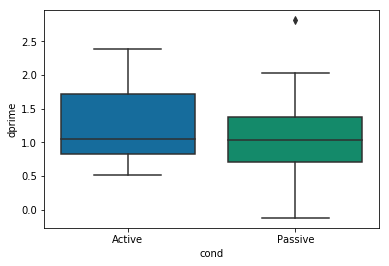

In [187]:
sns.boxplot(x='cond', y='dprime', data=dprimedf, palette='colorblind')

In [209]:
# collapsed across context & HIGH confidence responses only!!
type_dict = {0:'hit', 1:'fa'}
cond_dict = {'active':'Active', 'passive':'Passive'}
props_list = []
for row, ldf in rencode.groupby(by=['sub', 'cond', 'old/new', 'recog confidence']):
    sub, cond, old_new, conf = row
    if conf != 'high':
        continue
    count = ldf['accuracy'].count()
    prop_correct = ldf['accuracy'].sum()/count
    if old_new == 1:
        prop_correct = 1-prop_correct
    
    sub_dict = {'sub':sub, 'cond':cond_dict[cond], 'trialtype':type_dict[old_new], 'prop':prop_correct, 'count':count}
    props_list.append(sub_dict)
propsdf_high = pd.DataFrame(props_list)

for ind, row in propsdf_high.iterrows():
    halfprop = .5/row['count']
    if row['prop'] == 1:
        propsdf_high.loc[ind,'adjusted_prop'] = 1-halfprop
    elif row['prop'] == 0:
        propsdf_high.loc[ind,'adjusted_prop'] = halfprop
    else: propsdf_high.loc[ind,'adjusted_prop'] = row['prop']

dprimedf_high = propsdf_high.pivot_table(index=['sub','cond'], 
                          columns='trialtype')['adjusted_prop'].reset_index()
dprimedf_high['dprime'] = Z(dprimedf_high['hit']) - Z(dprimedf_high['fa'])
dprimedf_high

trialtype,sub,cond,fa,hit,dprime
0,701,Active,0.109091,0.576923,1.425405
1,701,Passive,0.135593,0.354167,0.726239
2,702,Active,0.119048,0.641026,1.540963
3,702,Passive,0.113636,0.711111,1.764048
4,703,Active,0.071429,0.931034,2.948774
5,703,Passive,0.125000,0.814815,2.046129
6,704,Active,0.021277,0.860000,3.108388
7,704,Passive,0.022222,0.605263,2.276869
8,705,Active,0.011628,0.976190,4.249958
9,705,Passive,0.009804,0.944444,3.926987


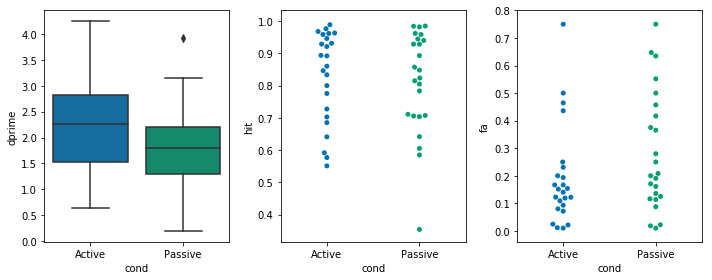

In [162]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 4))

ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

sns.boxplot(x='cond', y='dprime', data=dprimedf_high, palette='colorblind', ax = ax1)
sns.swarmplot(x='cond', y='hit', data=dprimedf_high, palette='colorblind', ax = ax2)
sns.swarmplot(x='cond', y='fa', data=dprimedf_high, palette='colorblind', ax = ax3)
fig.tight_layout()

In [197]:
score_list = []
for row, ldf in rencode.groupby(by=['sub','cond']):
    sub, cond = row
    scores = {}
    trialtype = ldf['old/new']
    resp = ldf['recog_answer']

    cm=confusion_matrix(trialtype, resp)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', vmin=0, vmax=.8)
#     plt.title(cond)
#     plt.show()
    
    score_funcs = [('recall', recall_score), ('precision', precision_score), ('f1', f1_score)]
    for fun_name, fun in score_funcs:
        score = fun(trialtype, resp)
        scores[fun_name] = score
    scores['cond'] = cond
    scores['sub'] = sub
    score_list.append(scores)
scoresdf=pd.DataFrame(score_list)  
scoresdf  


,cond,f1,precision,recall,sub
0,active,0.670520,0.651685,0.690476,701
1,passive,0.663102,0.601942,0.738095,701
2,active,0.715789,0.641509,0.809524,702
3,passive,0.697143,0.670330,0.726190,702
4,active,0.795322,0.781609,0.809524,703
5,passive,0.712500,0.750000,0.678571,703
6,active,0.795322,0.781609,0.809524,704
7,passive,0.726257,0.684211,0.773810,704
8,active,0.881356,0.838710,0.928571,705
9,passive,0.896175,0.828283,0.976190,705


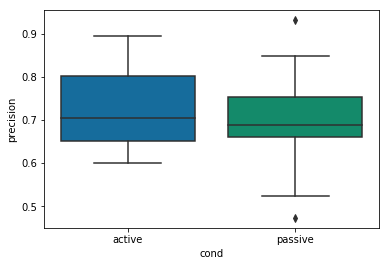

In [207]:
sns.boxplot(x='cond', y='precision', data = scoresdf, palette = 'colorblind')

In [19]:
old=rencode[rencode['old/new']==0]
new=rencode[rencode['old/new']==1]

In [20]:
old_means=pd.DataFrame(old.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].mean())
old_means.reset_index(inplace=True)

In [21]:
old_count=pd.DataFrame(old.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].count())
old_count.reset_index(inplace=True)


In [22]:
new_means=pd.DataFrame(new.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].mean())
new_means.reset_index(inplace=True)
new_means

def fa(x):
    return 1-x

new_means['fa']=new_means['accuracy'].apply(fa)

In [23]:
new_count=pd.DataFrame(new.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].count())
new_count.reset_index(inplace=True)

In [24]:
old_means.set_index('sub', inplace=True)
new_means.set_index('sub', inplace=True)
old_count.set_index('sub', inplace=True)
new_count.set_index('sub', inplace=True)

In [25]:
old_means=old_means[old_means['recog confidence']==2]
new_means=new_means[new_means['recog confidence']==2]
old_high=old_count[old_count['recog confidence']==2]
new_high=new_count[new_count['recog confidence']==2]
old_means.shape

(96, 4)

In [26]:
old_means.drop(index=722, inplace=True)
new_means.drop(index=722, inplace=True)
old_high.drop(index=722, inplace=True)
new_high.drop(index=722, inplace=True)
old_means.shape

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(92, 4)

In [27]:
old_high.rename(columns={'accuracy':'old_count'}, inplace=True)
new_high.rename(columns={'accuracy':'new_count'}, inplace=True)

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [28]:
old_means.rename(columns={'recog confidence':'conf', 'accuracy':'hit'}, inplace=True)

new_tmp=new_means[['fa']]
old_count=old_high[['old_count']]
new_count=new_high[['new_count']]
old_new_means=pd.concat([old_means, new_tmp, old_count, new_count], axis=1)

In [29]:
old_new_means.drop(index=707, inplace=True)
old_new_means.drop(index=724, inplace=True)

old_new_means.reset_index(inplace=True)

In [30]:
for ind, row in old_new_means.iterrows():
    halfhit=.5/row['old_count']
    halffa=.5/row['new_count']
    hit=row['hit']
    fa=row['fa']
    if hit==1:
        hit=1-halfhit
    if hit==0:
        hit=halfhit
    if fa==1:
        fa=1-halffa
    if fa==0:
        fa=halffa
    dprime=Z(hit)-Z(fa)    
    old_new_means.loc[ind,'adjusted_hit']=hit
    old_new_means.loc[ind,'adjusted_fa']=fa
    old_new_means.loc[ind,'dprime']=dprime


In [48]:
old_new_means

,sub,cond,cxtcond,conf,hit,fa,old_count,new_count,adjusted_hit,adjusted_fa,dprime
0,701,0,0,2,0.695652,0.153846,23,26,0.695652,0.153846,1.532012
1,701,0,1,2,0.482759,0.068966,29,29,0.482759,0.068966,1.440309
2,701,1,0,2,0.307692,0.071429,26,28,0.307692,0.071429,0.962832
3,701,1,1,2,0.409091,0.193548,22,31,0.409091,0.193548,0.635010
4,702,0,0,2,0.647059,0.000000,17,19,0.647059,0.026316,2.315323
5,702,0,1,2,0.636364,0.217391,22,23,0.636364,0.217391,1.129790
6,702,1,0,2,0.714286,0.136364,21,22,0.714286,0.136364,1.662752
7,702,1,1,2,0.708333,0.090909,24,22,0.708333,0.090909,1.883700
8,703,0,0,2,1.000000,0.142857,13,14,0.961538,0.142857,2.836396
9,703,0,1,2,0.875000,0.000000,16,14,0.875000,0.035714,2.953092


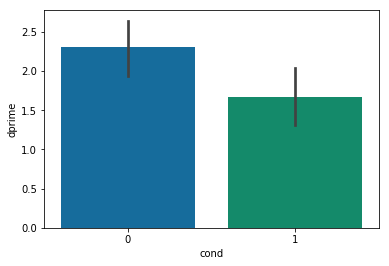

In [41]:
sns.barplot(x='cond', y='dprime', data=old_new_means[old_new_means['cxtcond']==0], palette='colorblind')

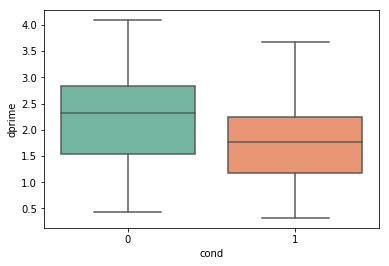

In [49]:
sns.boxplot(x='cond', y='dprime', data=old_new_means, palette='Set2')

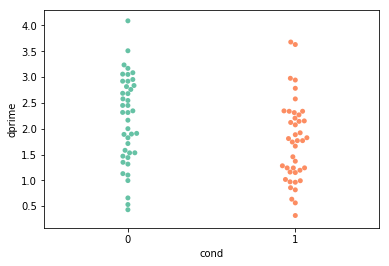

In [50]:
sns.swarmplot(x='cond', y='dprime', data=old_new_means, palette='Set2')